In [404]:
!pip install pandas matplotlib numpy statsmodels seaborn scipy -q


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [405]:
# Import all datasets for sit to stand
import pandas as pd
from data_collector import get_sit_to_stand_paths, get_sit_to_stand_challenge_paths, get_water_task_paths, get_water_task_challenge_paths, get_step_count_paths, get_step_count_challenge_paths
import numpy as np

task = 'sit2stand'
if task == 'sit2stand':
    paths_standard = get_sit_to_stand_paths()
    paths_challenge = get_sit_to_stand_challenge_paths()
elif task == 'water':
    paths_standard = get_water_task_paths()
    paths_challenge = get_water_task_challenge_paths()
elif task == 'step_count':
    paths_standard = get_step_count_paths()
    paths_challenge = get_step_count_challenge_paths()


dfs_stand = [pd.read_csv(path) for path in paths_standard]
dfs_stand_challenge = [pd.read_csv(path) for path in paths_challenge]

# For each dataframe, add a new column 'time_s' which is the time in seconds from the first timestamp
for df in dfs_stand:
    df['time_s'] = (df['timestamp_ms'] - df['timestamp_ms'].min()) / 1000


for df in dfs_stand_challenge:
    df['time_s'] = (df['timestamp_ms'] - df['timestamp_ms'].min()) / 1000

if task=='step_count':
    # rename column from acceleration_m/s²_x to 'freeAcceleration_m/s²_x' for x y and z
    dfs_stand = [df.rename(columns={'acceleration_m/s²_x': 'freeAcceleration_m/s²_x', 'acceleration_m/s²_y': 'freeAcceleration_m/s²_y', 'acceleration_m/s²_z': 'freeAcceleration_m/s²_z'}) for df in dfs_stand]
    dfs_stand_challenge = [df.rename(columns={'acceleration_m/s²_x': 'freeAcceleration_m/s²_x', 'acceleration_m/s²_y': 'freeAcceleration_m/s²_y', 'acceleration_m/s²_z': 'freeAcceleration_m/s²_z'}) for df in dfs_stand_challenge]

# Calculate magnitude of acceleration 
for df in dfs_stand:
    df['acceleration_magnitude'] = np.sqrt(
        df['freeAcceleration_m/s²_x']**2 + 
        df['freeAcceleration_m/s²_y']**2 + 
        df['freeAcceleration_m/s²_z']**2
    )

for df in dfs_stand_challenge:
    df['acceleration_magnitude'] = np.sqrt(
        df['freeAcceleration_m/s²_x']**2 + 
        df['freeAcceleration_m/s²_y']**2 + 
        df['freeAcceleration_m/s²_z']**2
    )


df_standard = dfs_stand[0]
df_challenge = dfs_stand_challenge[0]

print(f"Using data from {paths_standard[0]} and {paths_challenge[0]}")

Data directory to look in: /Users/ashish/Desktop/DS4W/sensorhub-analysis/data
Sub directories for each Device ID found: ['f3eba7e5-dbda-4f4c-9fa8-8e8308b334f6', '5f680dfb-2510-4790-8f10-cb8724e7004c', '3c2d2423-8ac8-4a8c-95e2-aba5cc14abf8']
Data directory to look in: /Users/ashish/Desktop/DS4W/sensorhub-analysis/data
Sub directories for each Device ID found: ['f3eba7e5-dbda-4f4c-9fa8-8e8308b334f6', '5f680dfb-2510-4790-8f10-cb8724e7004c', '3c2d2423-8ac8-4a8c-95e2-aba5cc14abf8']
Using data from /Users/ashish/Desktop/DS4W/sensorhub-analysis/data/3c2d2423-8ac8-4a8c-95e2-aba5cc14abf8/csv/Recordings_Signal_Data/2025-05-08T12_59_06Z-sit_to_stand/sit_to_stand_imu.csv and /Users/ashish/Desktop/DS4W/sensorhub-analysis/data/3c2d2423-8ac8-4a8c-95e2-aba5cc14abf8/csv/Recordings_Signal_Data/2025-05-12T06_58_28Z-sit_to_stand_challenge/sit_to_stand_imu.csv


## Experimental Design

- **Within-subject study**: Each participant (N = 5) performs:
  - Sit-to-stand under **normal** conditions
  - Sit-to-stand while doing a **cognitive task** (serial subtraction)

- **Data collected**:
  - Timestamped acceleration on 3 axes (x, y, z) for ~30 seconds per trial

---

## Step 1: Compute Acceleration Magnitude

We reduce the 3D accelerometer signal into a single scalar by computing the **magnitude** of free acceleration at each time point:

$$
\text{acc_mag}(t) = \sqrt{x_t^2 + y_t^2 + z_t^2}
$$

This gives us a time-series that reflects total body movement intensity.

---

## Step 2: Feature Extraction : Mean Acceleration

We summarize the signal for each trial (one per participant per condition) by computing the **mean acceleration magnitude**:

$$
\bar{a} = \frac{1}{T} \sum_{t=1}^{T} \text{acc_mag}(t)
$$

Where:
- T is the number of time points in the trial
- a' represents the average movement intensity

---

## 🔍 Step 3: Statistical Testing : Paired t-test

To assess whether the cognitive condition affects mean acceleration, we compare the values **within participants** using a **paired t-test**.

Let the difference for each participant be:

$$
D_i = a_{\text{normal},i} - a_{\text{cognitive},i}
$$

We test the null hypothesis:

$$
H_0: \mu_D = 0 \quad \text{(no difference)}
$$

With the t-statistic:

$$
t = \frac{\bar{D}}{s_D / \sqrt{n}}
$$

Where:
- D'  is the mean of the differences
- s_D is the standard deviation of the differences
- n is the number of participants

If the resulting **p-value < 0.05**, we reject \( H_0 \), concluding that cognitive load **significantly alters** movement.

---

In [406]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Convert timestamps to datetime for better x-axis labels
# Create a relative time in seconds from the first timestamp
def visualize_data(df):
    # Plot the acceleration data
    plt.figure(figsize=(12, 8))

    # Plot each axis
    plt.subplot(3, 1, 1)
    plt.plot(df['time_s'], df['freeAcceleration_m/s²_x'], 'r-', label='X-axis')
    plt.ylabel('Acceleration (m/s²)')
    plt.title('Free Acceleration X-axis')
    plt.grid(True)
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(df['time_s'], df['freeAcceleration_m/s²_y'], 'g-', label='Y-axis')
    plt.ylabel('Acceleration (m/s²)')
    plt.title('Free Acceleration Y-axis')
    plt.grid(True)
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(df['time_s'], df['freeAcceleration_m/s²_z'], 'b-', label='Z-axis')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Acceleration (m/s²)')
    plt.title('Free Acceleration Z-axis')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Combined view of all three axes
    plt.figure(figsize=(12, 6))
    plt.plot(df['time_s'], df['freeAcceleration_m/s²_x'], 'r-', label='X-axis')
    plt.plot(df['time_s'], df['freeAcceleration_m/s²_y'], 'g-', label='Y-axis')
    plt.plot(df['time_s'], df['freeAcceleration_m/s²_z'], 'b-', label='Z-axis')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Acceleration (m/s²)')
    plt.title('Free Acceleration - All Axes')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot the magnitude
    plt.figure(figsize=(12, 5))
    plt.plot(df['time_s'], df['acceleration_magnitude'], 'k-')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Acceleration Magnitude (m/s²)')
    plt.title('Magnitude of Acceleration')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

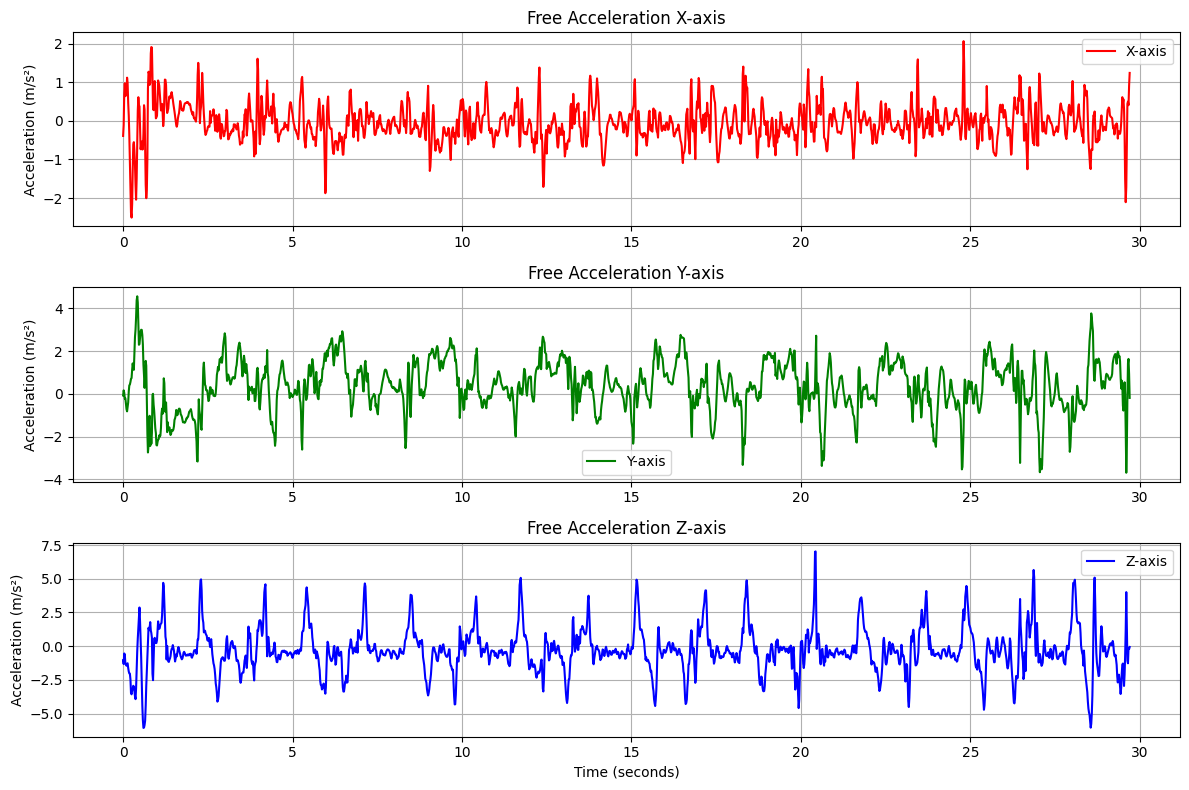

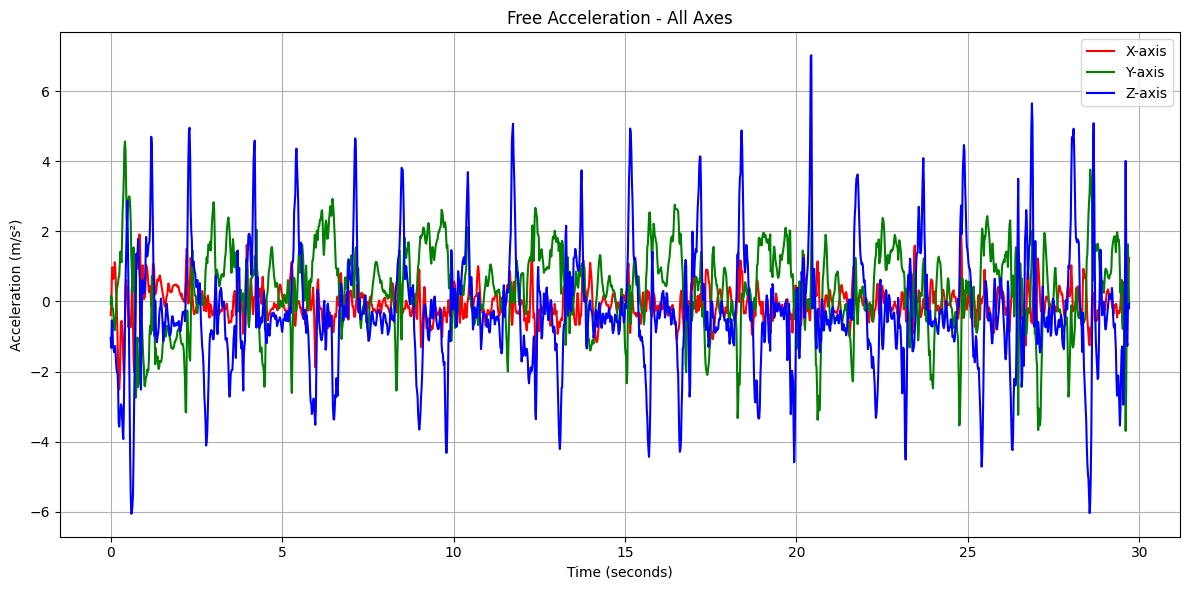

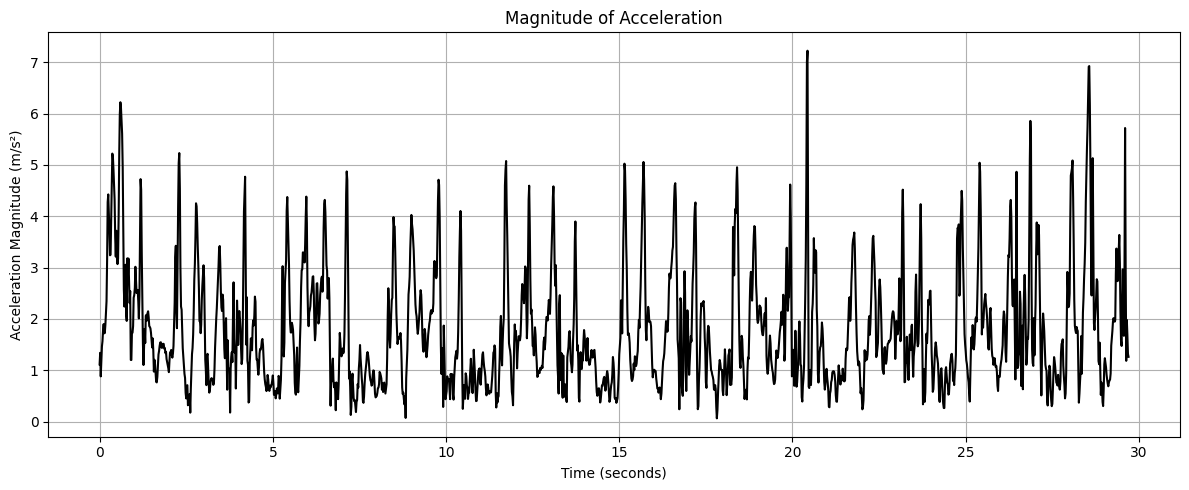

In [407]:
# Visualize normal data
visualize_data(df_standard)


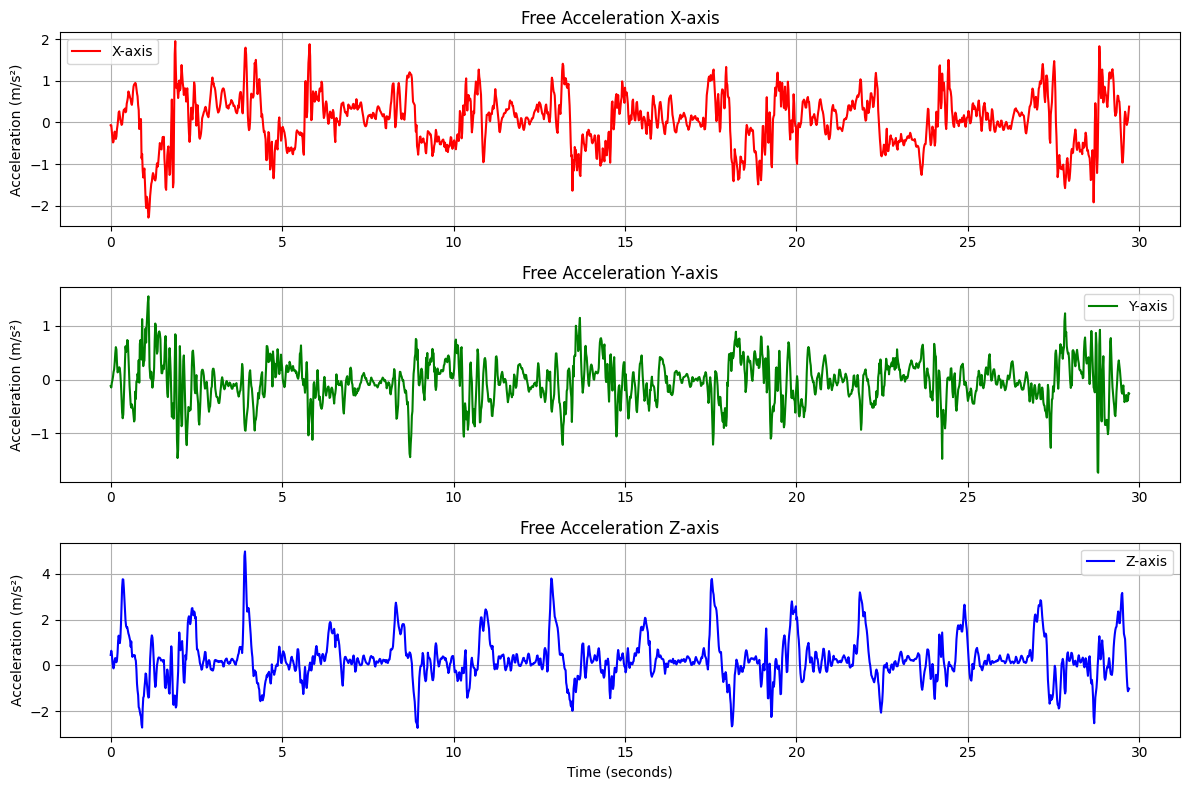

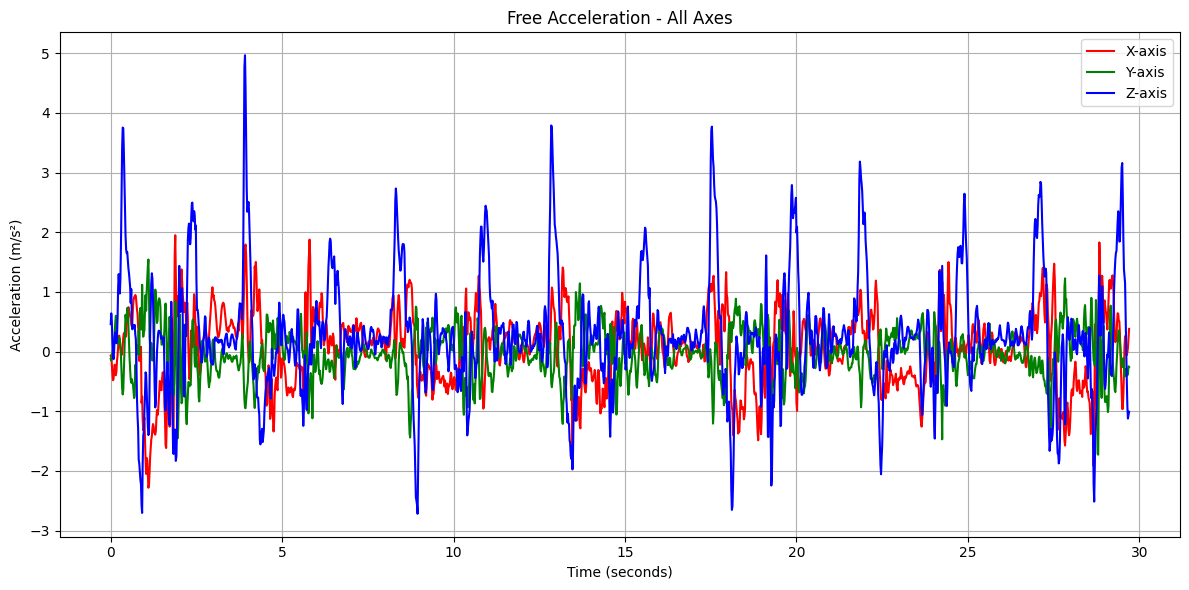

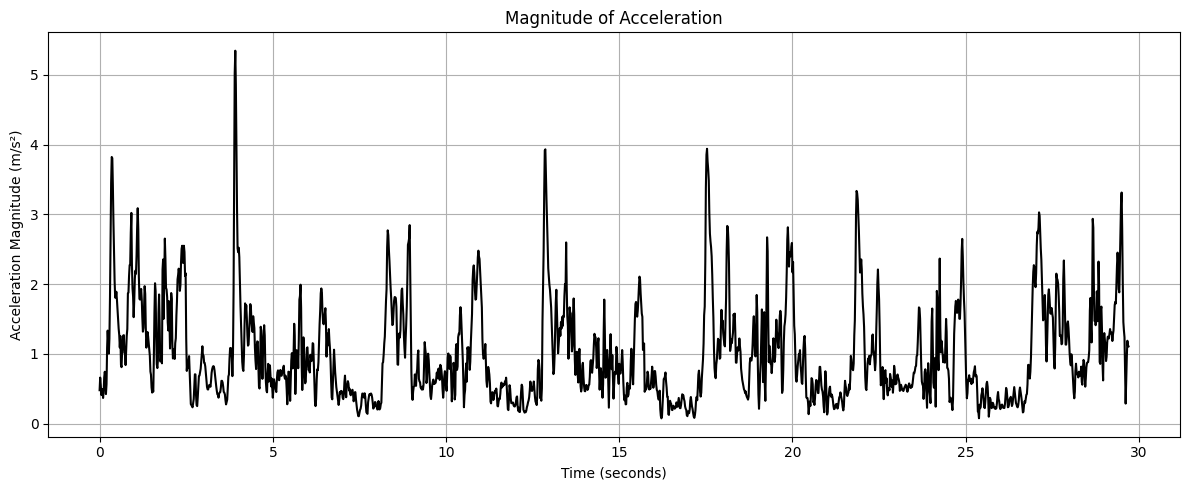

In [408]:
# Visualize challenge data
visualize_data(df_challenge)

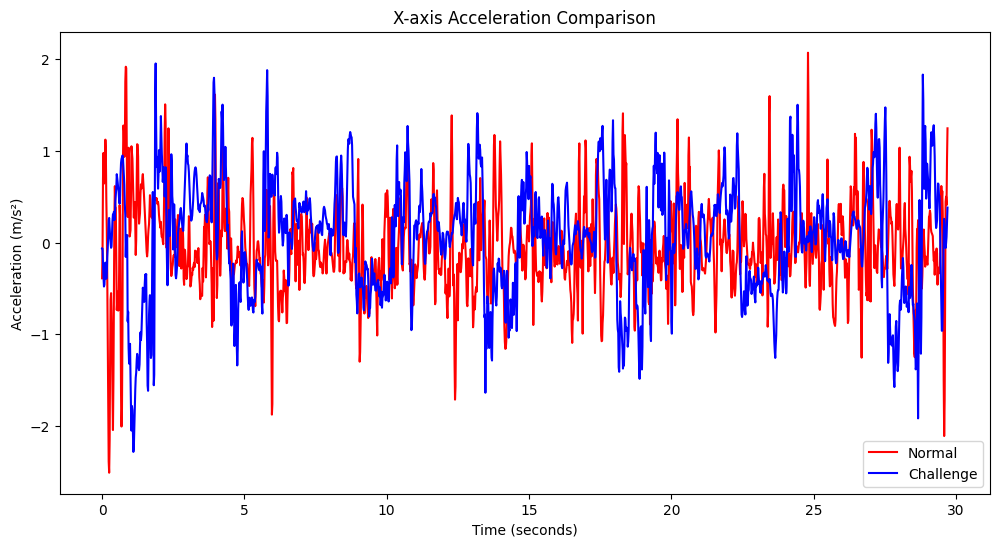

In [409]:
# Compare both data x-axis acceleration
def compare_acceleration_x(df, df_challenge):
    plt.figure(figsize=(12, 6))
    plt.plot(df['time_s'], df['freeAcceleration_m/s²_x'], 'r-', label='Normal')
    plt.plot(df_challenge['time_s'], df_challenge['freeAcceleration_m/s²_x'], 'b-', label='Challenge')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Acceleration (m/s²)')
    plt.title('X-axis Acceleration Comparison')
    plt.legend()
    plt.show()

# Compare both data x-axis acceleration
compare_acceleration_x(df_standard, df_challenge)





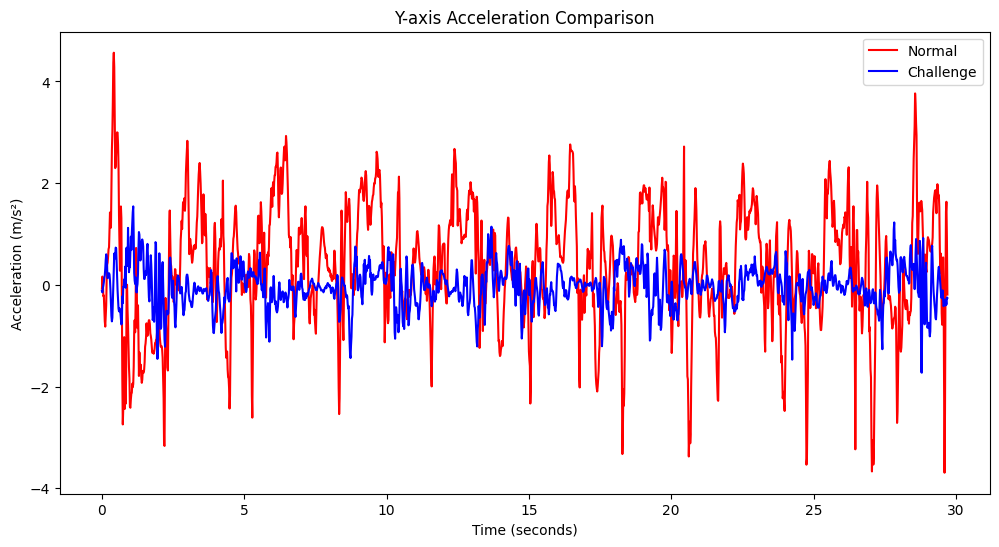

In [410]:
# Compare both data y-axis acceleration
def compare_acceleration_y(df, df_challenge):
    plt.figure(figsize=(12, 6))
    plt.plot(df['time_s'], df['freeAcceleration_m/s²_y'], 'r-', label='Normal')
    plt.plot(df_challenge['time_s'], df_challenge['freeAcceleration_m/s²_y'], 'b-', label='Challenge')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Acceleration (m/s²)')
    plt.title('Y-axis Acceleration Comparison')
    plt.legend()
    plt.show()

# Compare both data y-axis acceleration
compare_acceleration_y(df_standard, df_challenge)





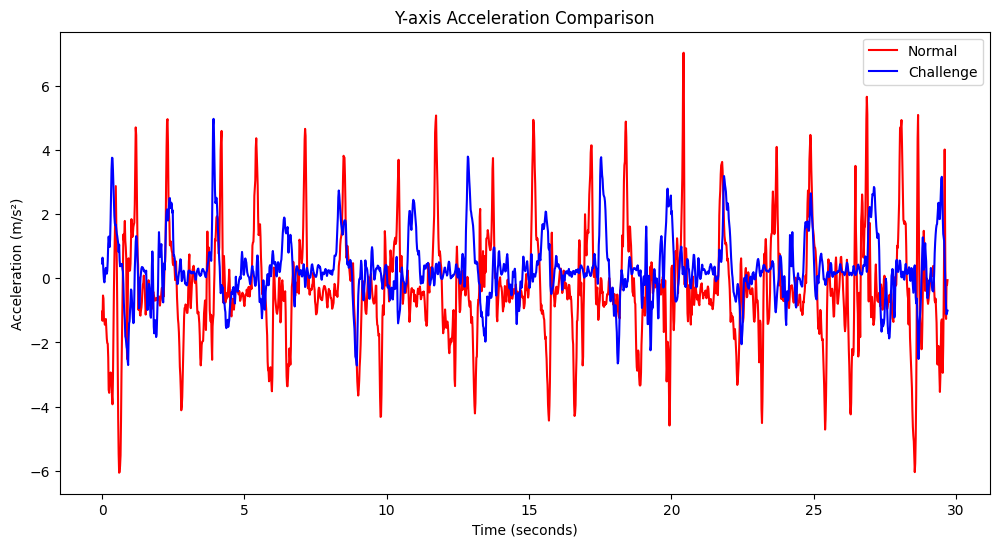

In [411]:
# Compare both data z-axis acceleration
def compare_acceleration_z(df, df_challenge):
    plt.figure(figsize=(12, 6))
    plt.plot(df['time_s'], df['freeAcceleration_m/s²_z'], 'r-', label='Normal')
    plt.plot(df_challenge['time_s'], df_challenge['freeAcceleration_m/s²_z'], 'b-', label='Challenge')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Acceleration (m/s²)')
    plt.title('Y-axis Acceleration Comparison')
    plt.legend()
    plt.show()

# Compare both data z-axis acceleration
compare_acceleration_z(df_standard, df_challenge)





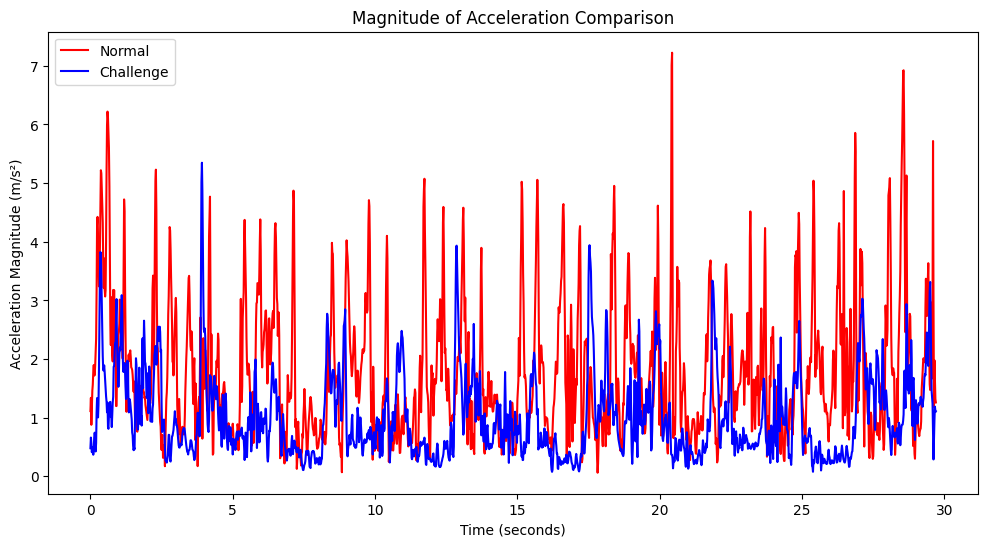

In [412]:
# Compare both data magnitude of acceleration
def compare_acceleration_magnitude(df, df_challenge):
    plt.figure(figsize=(12, 6))
    plt.plot(df['time_s'], df['acceleration_magnitude'], 'r-', label='Normal')
    plt.plot(df_challenge['time_s'], df_challenge['acceleration_magnitude'], 'b-', label='Challenge')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Acceleration Magnitude (m/s²)')
    plt.title('Magnitude of Acceleration Comparison')
    plt.legend()
    plt.show()

# Compare both data magnitude of acceleration
compare_acceleration_magnitude(df_standard, df_challenge)


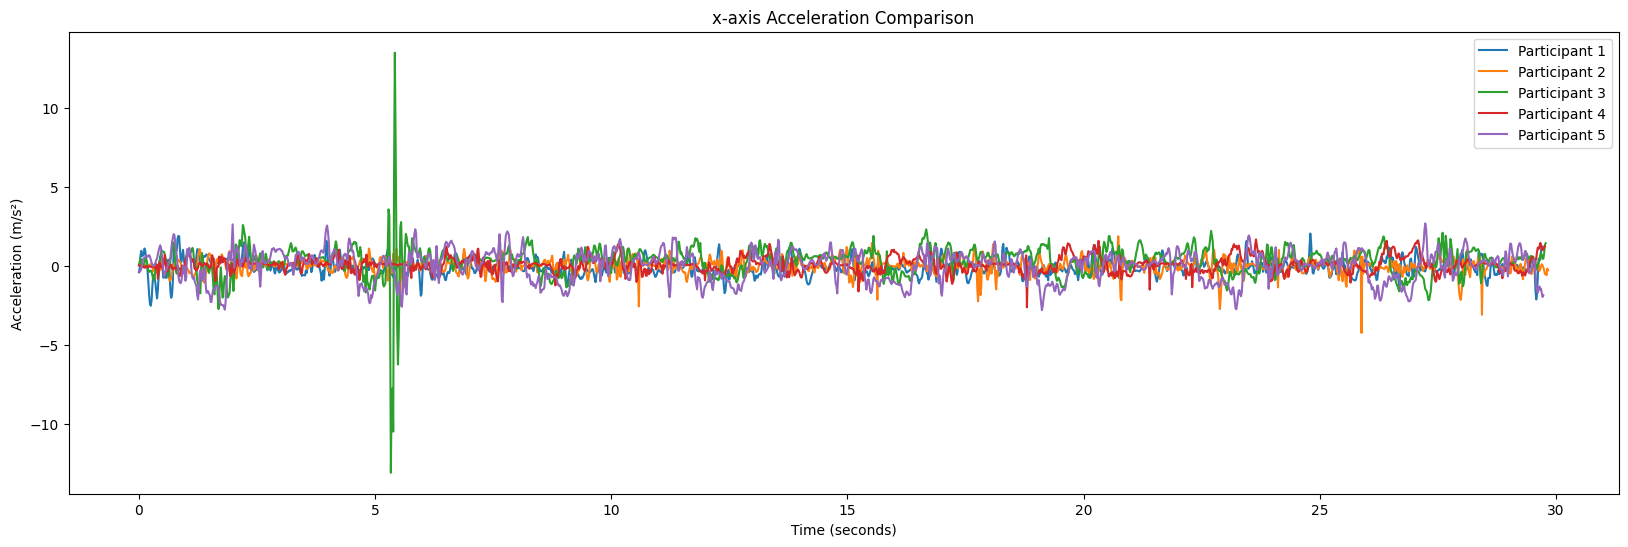

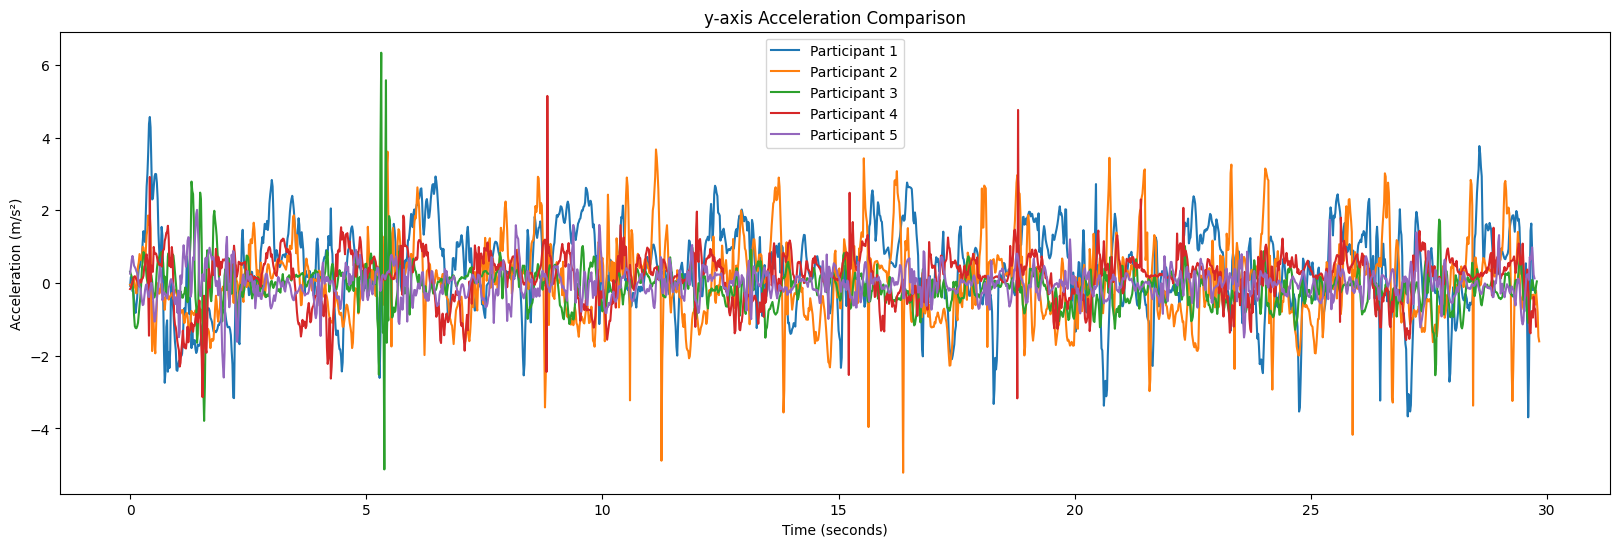

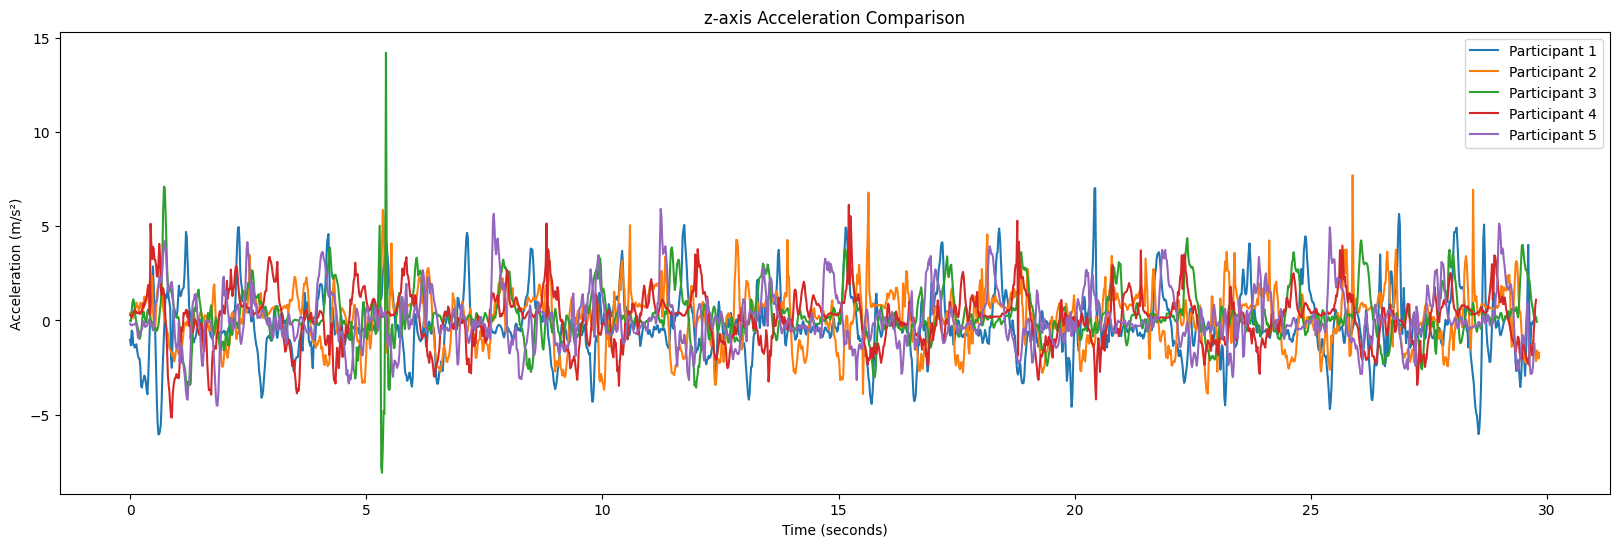

In [413]:
# Compare x-acceleration across all participants
def compare_acceleration_x_all(dfs, axis='x'):
    plt.figure(figsize=(20, 6))
    for i, df in enumerate(dfs):
        plt.plot(df['time_s'], df[f'freeAcceleration_m/s²_{axis}'], label=f'Participant {i+1}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Acceleration (m/s²)')
    plt.title(f'{axis}-axis Acceleration Comparison')

    plt.legend()
    plt.show()


# Compare x-acceleration across all participants
compare_acceleration_x_all(dfs_stand)

# Compare x-acceleration across all participants
compare_acceleration_x_all(dfs_stand, 'y')

# Compare x-acceleration across all participants
compare_acceleration_x_all(dfs_stand, 'z')



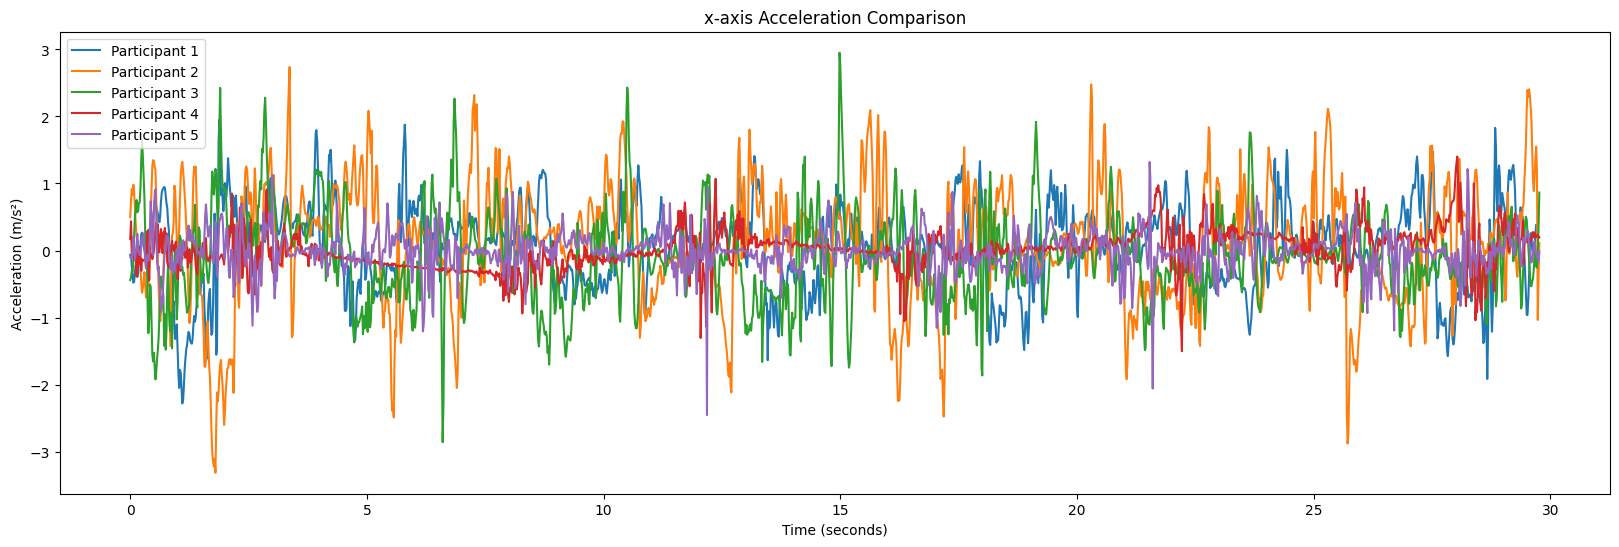

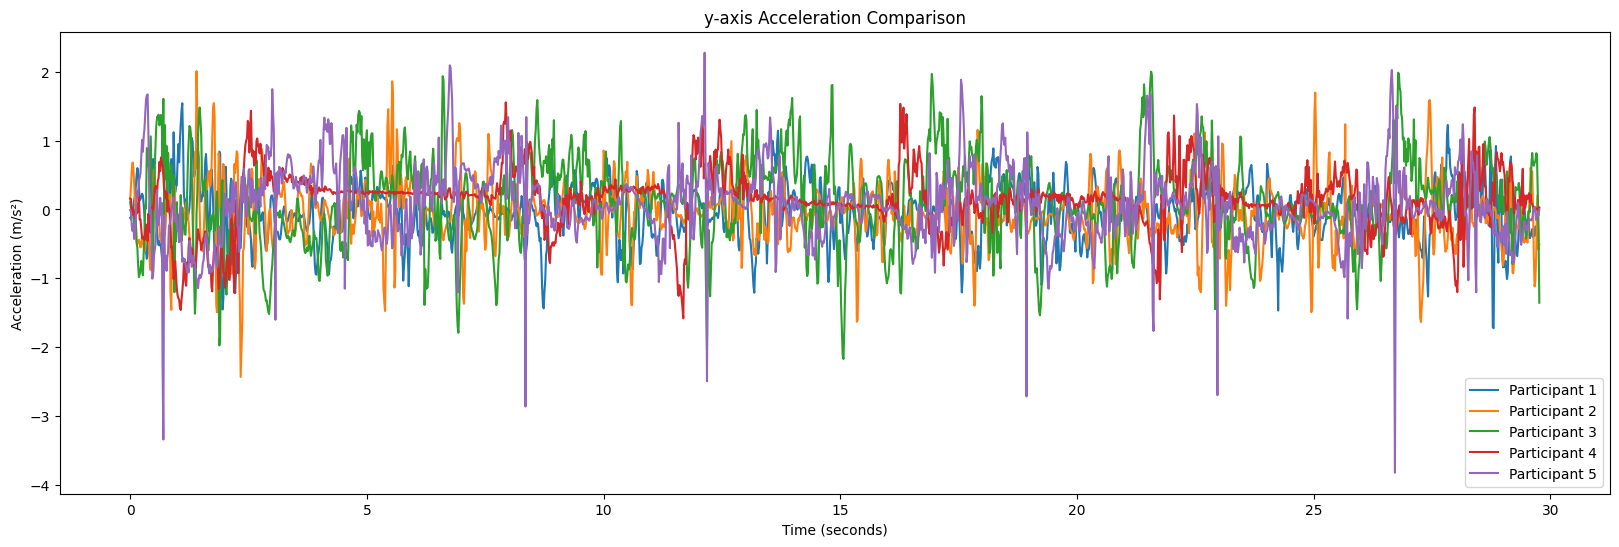

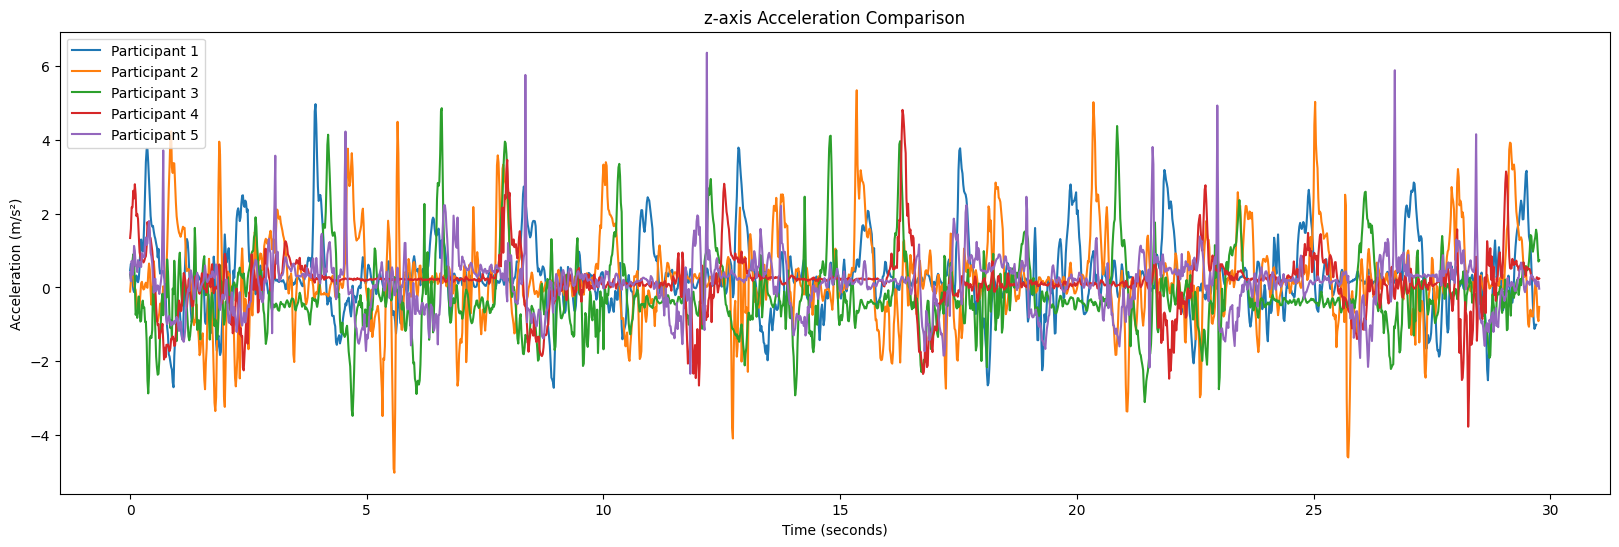

In [414]:
# Compare x-acceleration across all participants
compare_acceleration_x_all(dfs_stand_challenge, 'x')

# Compare x-acceleration across all participants
compare_acceleration_x_all(dfs_stand_challenge, 'y')

# Compare x-acceleration across all participants
compare_acceleration_x_all(dfs_stand_challenge, 'z')


In [415]:
len(dfs_stand), dfs_stand

(5,
 [       timestamp_ms  timestamp_μs  freeAcceleration_m/s²_x  \
  0     1746709146601     231101705                -0.390118   
  1     1746709146618     231118372                -0.103113   
  2     1746709146634     231135039                 0.693871   
  3     1746709146651     231151706                 0.976024   
  4     1746709146668     231168373                 0.641669   
  ...             ...           ...                      ...   
  1778  1746709176235     260735631                 0.444211   
  1779  1746709176252     260752298                 0.499439   
  1780  1746709176268     260768965                 0.407235   
  1781  1746709176285     260785632                 0.912732   
  1782  1746709176302     260802299                 1.244095   
  
        freeAcceleration_m/s²_y  freeAcceleration_m/s²_z  time_s  \
  0                   -0.076349                -1.039129   0.000   
  1                    0.163044                -1.324339   0.017   
  2                  

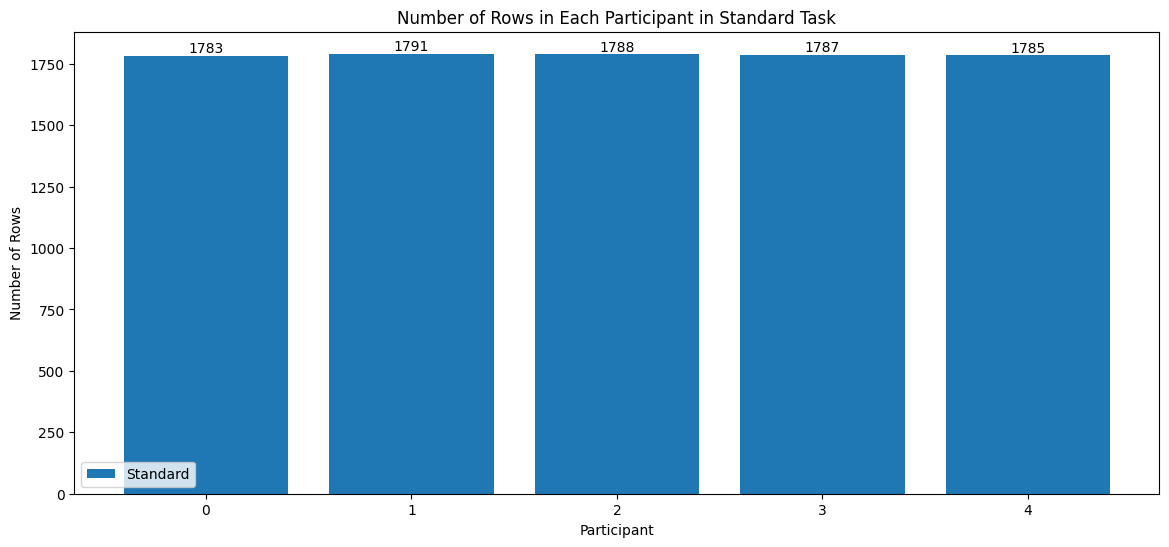

In [416]:
# Compare number of rows in each participant's data by plotting
import matplotlib.pyplot as plt

# Create a list to store the number of rows for each participant
num_rows_list_standard = [len(df) for df in dfs_stand]
num_rows_list_challenge = [len(df) for df in dfs_stand_challenge]

# PLot bar chart of number of rows for each participant with participant number on x-axis
plt.figure(figsize=(14, 6))
plt.bar(range(len(num_rows_list_standard)), num_rows_list_standard, label='Standard')
# Label each bar with the number of samples in the participant's data 
for i, num_rows in enumerate(num_rows_list_standard):
    plt.text(i, num_rows, str(num_rows), ha='center', va='bottom')
plt.xlabel('Participant')
plt.ylabel('Number of Rows')
plt.title('Number of Rows in Each Participant in Standard Task')
plt.legend()

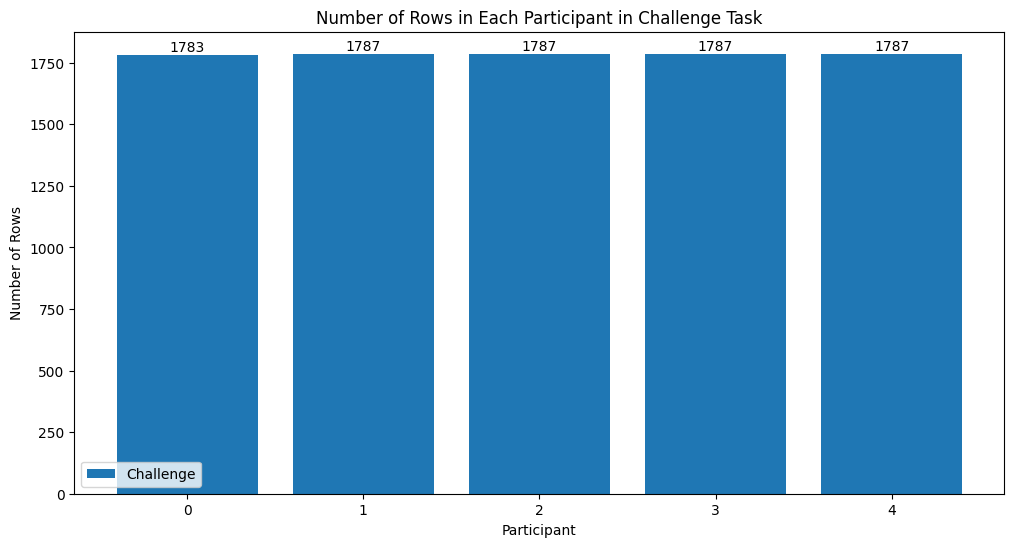

In [417]:
plt.figure(figsize=(12, 6))
plt.bar(range(len(num_rows_list_challenge)), num_rows_list_challenge, label='Challenge')
for i, num_rows in enumerate(num_rows_list_challenge):
    plt.text(i, num_rows, str(num_rows), ha='center', va='bottom')
plt.xlabel('Participant')
plt.ylabel('Number of Rows')
plt.title('Number of Rows in Each Participant in Challenge Task')
plt.legend()

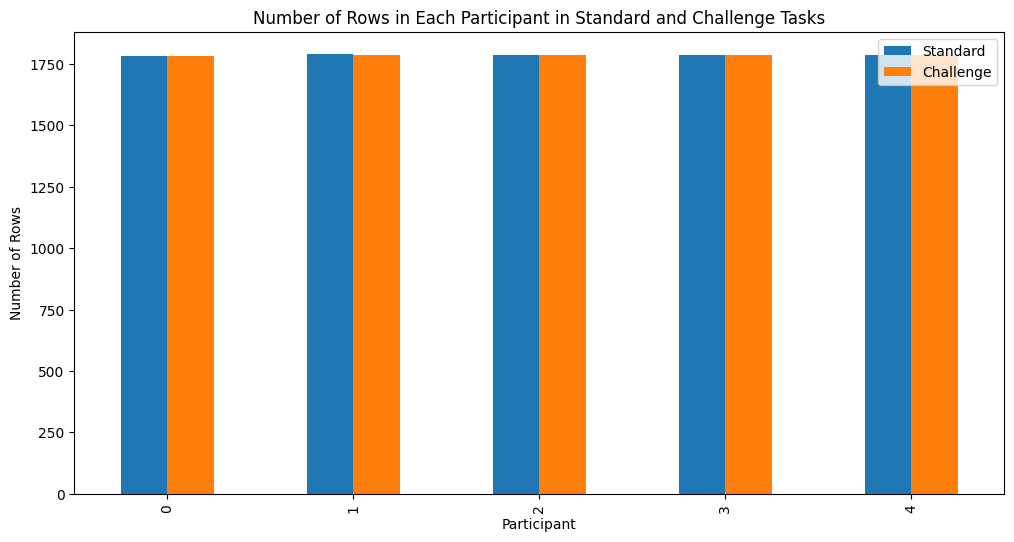

In [418]:
# Plot a double, non overlapping bar chart of number of rows for standard and challenge tasks
count_df = pd.DataFrame({
    'Standard': num_rows_list_standard,
    'Challenge': num_rows_list_challenge
})
count_df.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Participant')
plt.ylabel('Number of Rows')
plt.title('Number of Rows in Each Participant in Standard and Challenge Tasks')
plt.legend()

In [419]:
# Calculate mean acceleration for each axis per participant 
mean_acceleration_standard_x = [df['freeAcceleration_m/s²_x'].mean() for df in dfs_stand]
mean_acceleration_challenge_x = [df['freeAcceleration_m/s²_x'].mean() for df in dfs_stand_challenge]
mean_acceleration_standard_y = [df['freeAcceleration_m/s²_y'].mean() for df in dfs_stand]
mean_acceleration_challenge_y = [df['freeAcceleration_m/s²_y'].mean() for df in dfs_stand_challenge]
mean_acceleration_standard_z = [df['freeAcceleration_m/s²_z'].mean() for df in dfs_stand]
mean_acceleration_challenge_z = [df['freeAcceleration_m/s²_z'].mean() for df in dfs_stand_challenge]

# Plot and compare mean acceleration for each axis per participant
def plot_mean_acceleration(mean_acceleration_standard, mean_acceleration_challenge, axis='x'):
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(mean_acceleration_standard)), mean_acceleration_standard, label='Standard')
    plt.bar(range(len(mean_acceleration_challenge)), mean_acceleration_challenge, label='Challenge')
    # Label each bar with the mean acceleration, rounded to 2 decimal places
    for i, mean_acceleration in enumerate(mean_acceleration_standard):
        # write text in blue color
        plt.text(i, mean_acceleration, str(round(mean_acceleration, 4)), ha='center', va='bottom', color='blue')
    for i, mean_acceleration in enumerate(mean_acceleration_challenge_x):
        plt.text(i, mean_acceleration, str(round(mean_acceleration, 4)), ha='center', va='bottom', color='black')
    plt.xlabel('Participant')
    plt.ylabel(f"Mean Acceleration in {axis}-axis (m/s²)")
    plt.title('Mean Acceleration in Standard and Challenge Tasks')
    plt.legend()



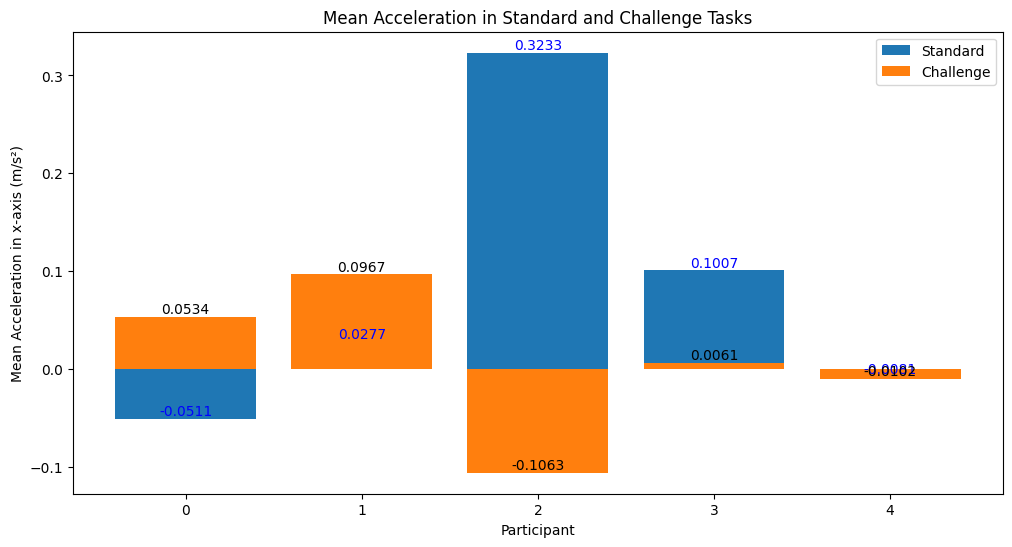

In [420]:
# Mean acceleration for x axis
plot_mean_acceleration(mean_acceleration_standard_x, mean_acceleration_challenge_x, 'x')



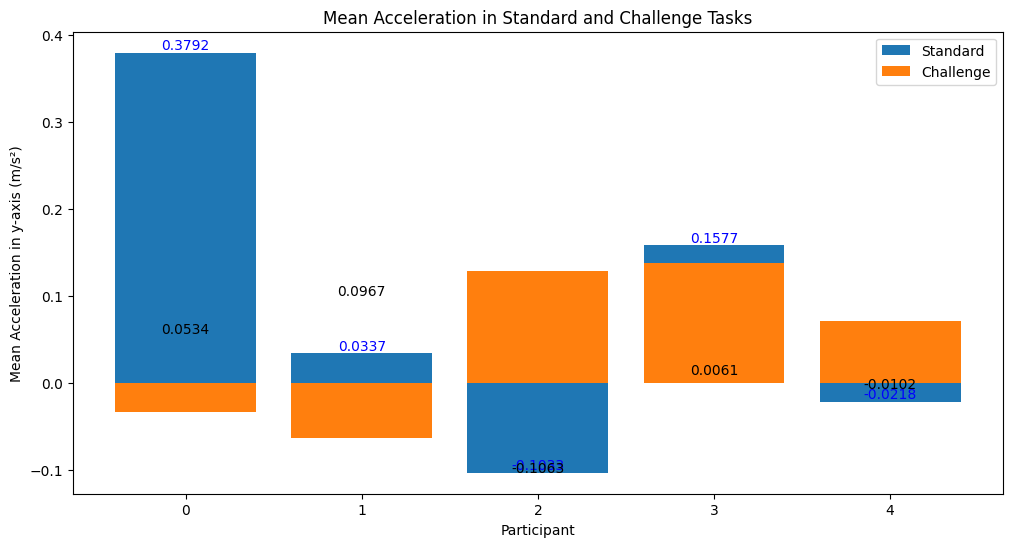

In [421]:
# Mean acceleration for y axis
plot_mean_acceleration(mean_acceleration_standard_y, mean_acceleration_challenge_y, 'y')

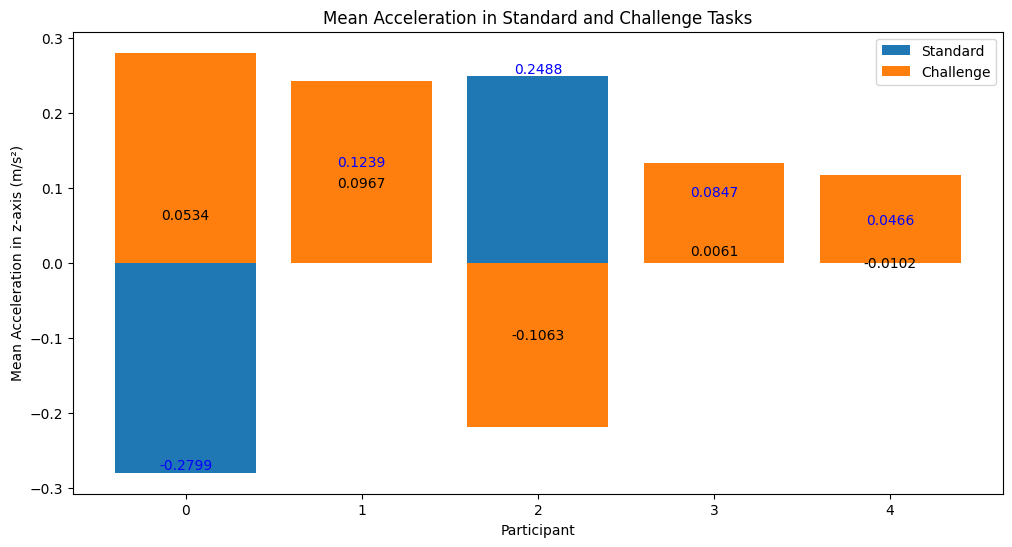

In [422]:
# Mean acceleration for z axis
plot_mean_acceleration(mean_acceleration_standard_z, mean_acceleration_challenge_z, 'z')

/var/folders/zp/3681gr8x5mg9vt0z3xbtlzx00000gn/T/ipykernel_91614/3602491626.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0, 0].legend()
/var/folders/zp/3681gr8x5mg9vt0z3xbtlzx00000gn/T/ipykernel_91614/3602491626.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1, 0].legend()
/var/folders/zp/3681gr8x5mg9vt0z3xbtlzx00000gn/T/ipykernel_91614/3602491626.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0, 1].legend()
/var/folders/zp/3681gr8x5mg9vt0z3xbtlzx00000gn/T/ipykernel_91614/3602491626.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label star

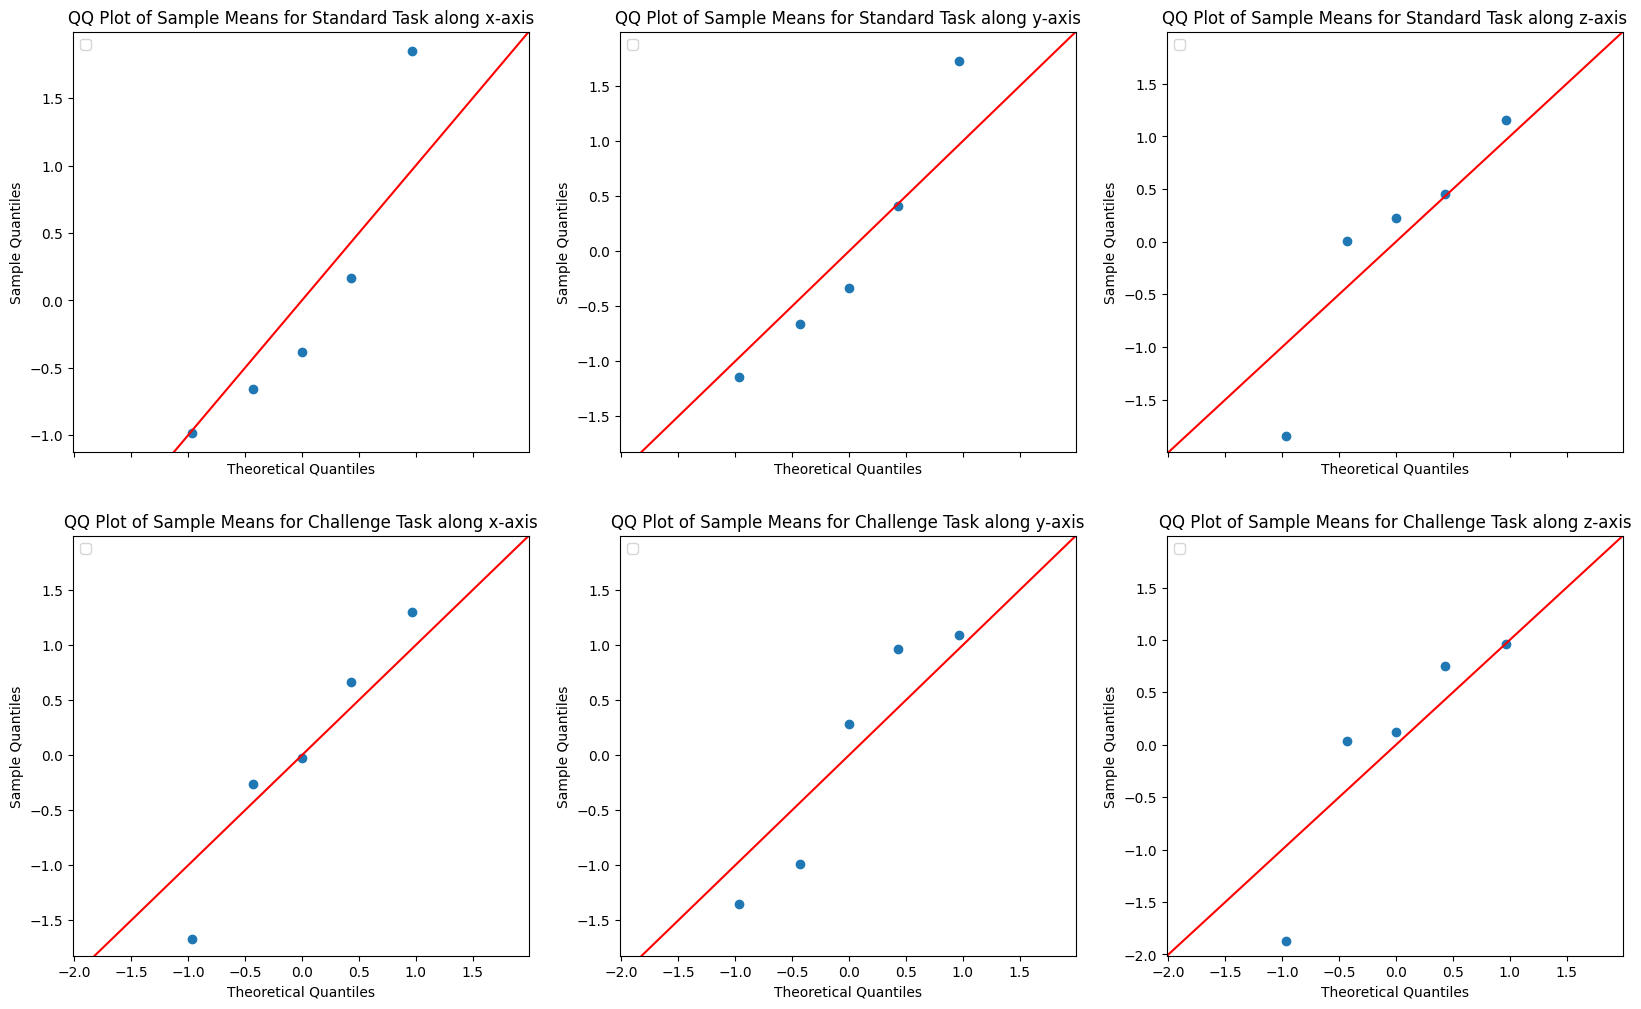

In [423]:
# Plot sample means using qq plots
import statsmodels.api as sm

# Create a list to store the sample means for each participant
sample_means_standard_x = np.array([df['freeAcceleration_m/s²_x'].mean() for df in dfs_stand])
sample_means_challenge_x = np.array([df['freeAcceleration_m/s²_x'].mean() for df in dfs_stand_challenge])
sample_means_standard_y = np.array([df['freeAcceleration_m/s²_y'].mean() for df in dfs_stand])
sample_means_challenge_y = np.array([df['freeAcceleration_m/s²_y'].mean() for df in dfs_stand_challenge])
sample_means_standard_z = np.array([df['freeAcceleration_m/s²_z'].mean() for df in dfs_stand])
sample_means_challenge_z = np.array([df['freeAcceleration_m/s²_z'].mean() for df in dfs_stand_challenge])

fig, axs = plt.subplots(2, 3, figsize=(20, 12), sharex=True)


# Plot qq plot of sample means and add labels
sm.qqplot(sample_means_standard_x, line='45', fit=True, ax=axs[0, 0])
axs[0, 0].set_xlabel('Theoretical Quantiles')
axs[0, 0].set_ylabel('Sample Quantiles')
axs[0, 0].set_title('QQ Plot of Sample Means for Standard Task along x-axis')
axs[0, 0].legend()

# Plot qq plot of sample means
sm.qqplot(sample_means_challenge_x, line='45', fit=True, ax=axs[1, 0])
axs[1, 0].set_xlabel('Theoretical Quantiles')
axs[1, 0].set_ylabel('Sample Quantiles')
axs[1, 0].set_title('QQ Plot of Sample Means for Challenge Task along x-axis')
axs[1, 0].legend()

# Plot qq plot of sample means
sm.qqplot(sample_means_standard_y, line='45', fit=True, ax=axs[0, 1])
axs[0, 1].set_xlabel('Theoretical Quantiles')
axs[0, 1].set_ylabel('Sample Quantiles')
axs[0, 1].set_title('QQ Plot of Sample Means for Standard Task along y-axis')
axs[0, 1].legend()

# Plot qq plot of sample means
sm.qqplot(sample_means_challenge_y, line='45', fit=True, ax=axs[1, 1])
axs[1, 1].set_xlabel('Theoretical Quantiles')
axs[1, 1].set_ylabel('Sample Quantiles')
axs[1, 1].set_title('QQ Plot of Sample Means for Challenge Task along y-axis')
axs[1, 1].legend()

# Plot qq plot of sample means
sm.qqplot(sample_means_standard_z, line='45', fit=True, ax=axs[0, 2])
axs[0, 2].set_xlabel('Theoretical Quantiles')
axs[0, 2].set_ylabel('Sample Quantiles')
axs[0, 2].set_title('QQ Plot of Sample Means for Standard Task along z-axis')
axs[0, 2].legend()

# Plot qq plot of sample means
sm.qqplot(sample_means_challenge_z, line='45', fit=True, ax=axs[1, 2])
axs[1, 2].set_xlabel('Theoretical Quantiles')
axs[1, 2].set_ylabel('Sample Quantiles')
axs[1, 2].set_title('QQ Plot of Sample Means for Challenge Task along z-axis')
axs[1, 2].legend()

In [424]:
# Calculate magnitude of acceleration for each participant
mean_acceleration_standard_magnitude = np.array([df['acceleration_magnitude'].mean() for df in dfs_stand])
mean_acceleration_challenge_magnitude = np.array([df['acceleration_magnitude'].mean() for df in dfs_stand_challenge])

mean_acceleration_standard_magnitude, mean_acceleration_challenge_magnitude

(array([1.78488787, 1.63689184, 1.39231585, 1.35709055, 1.45023621]),
 array([1.00407051, 1.23304809, 1.15220116, 0.69327856, 0.78111748]))

/var/folders/zp/3681gr8x5mg9vt0z3xbtlzx00000gn/T/ipykernel_91614/205138737.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
/var/folders/zp/3681gr8x5mg9vt0z3xbtlzx00000gn/T/ipykernel_91614/205138737.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


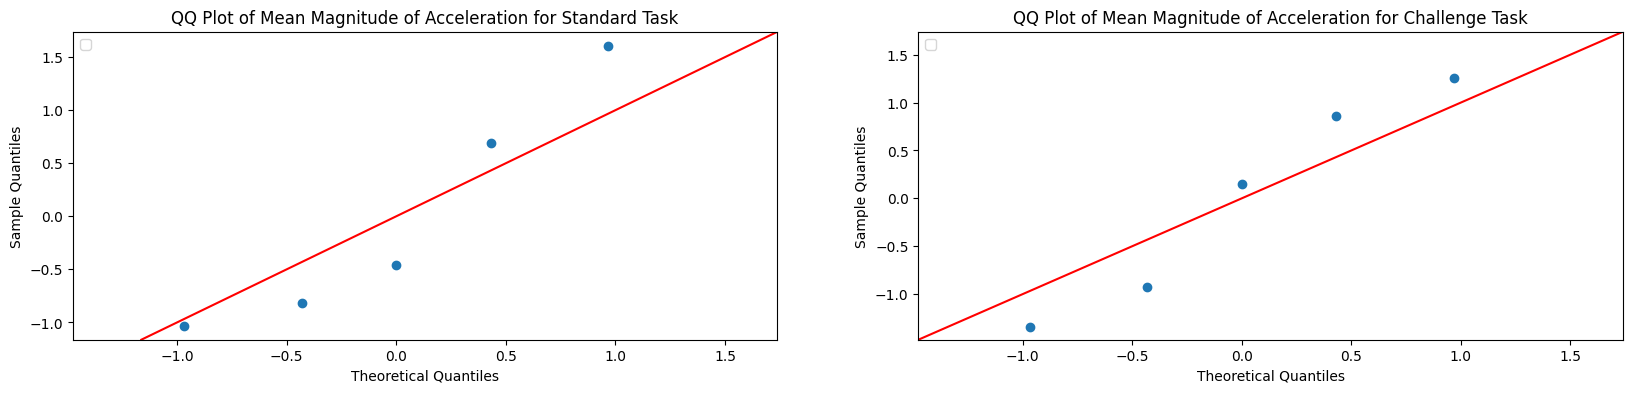

In [425]:
# Plot qq plot for mean acceleration of standard and challenge tasks
fig, axs = plt.subplots(1, 2, figsize=(20, 4), sharex=True)
# Plot qq plot for the mean magnitude of acceleration for standard and challenge tasks
sm.qqplot(mean_acceleration_standard_magnitude, line='45', fit=True, ax=axs[0])
axs[0].set_xlabel('Theoretical Quantiles')
axs[0].set_ylabel('Sample Quantiles')
axs[0].set_title('QQ Plot of Mean Magnitude of Acceleration for Standard Task')
axs[0].legend()

sm.qqplot(mean_acceleration_challenge_magnitude, line='45', fit=True, ax=axs[1])
axs[1].set_xlabel('Theoretical Quantiles')
axs[1].set_ylabel('Sample Quantiles')
axs[1].set_title('QQ Plot of Mean Magnitude of Acceleration for Challenge Task')
axs[1].legend()

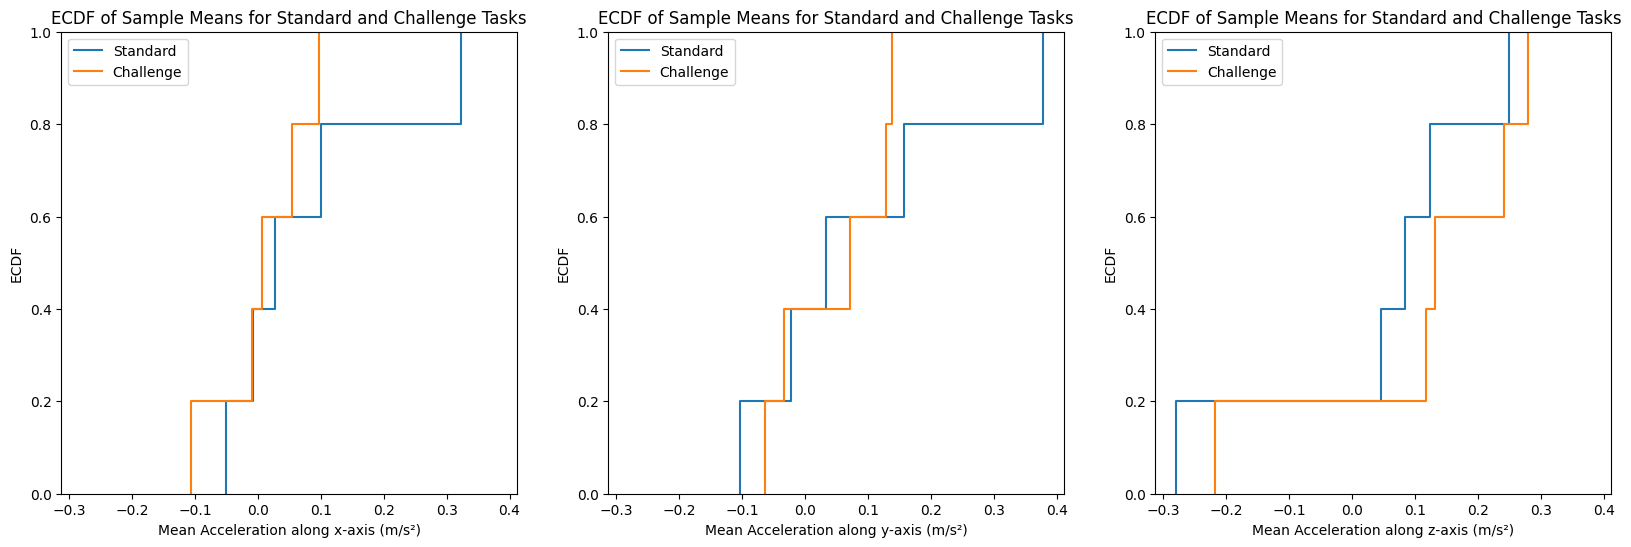

In [426]:
# Plot ecdf of sample means
import seaborn as sns

# Plot ecdf of sample means using subplots of grid 1,3 along x, y and z axis
fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharex=True)
sns.ecdfplot(sample_means_standard_x, label='Standard', ax=axs[0])
sns.ecdfplot(sample_means_challenge_x, label='Challenge', ax=axs[0])
axs[0].set_xlabel('Mean Acceleration along x-axis (m/s²)')
axs[0].set_ylabel('ECDF')
axs[0].set_title('ECDF of Sample Means for Standard and Challenge Tasks')
axs[0].legend()

sns.ecdfplot(sample_means_standard_y, label='Standard', ax=axs[1])
sns.ecdfplot(sample_means_challenge_y, label='Challenge', ax=axs[1])
axs[1].set_xlabel('Mean Acceleration along y-axis (m/s²)')
axs[1].set_ylabel('ECDF')
axs[1].set_title('ECDF of Sample Means for Standard and Challenge Tasks')
axs[1].legend()

sns.ecdfplot(sample_means_standard_z, label='Standard', ax=axs[2])
sns.ecdfplot(sample_means_challenge_z, label='Challenge', ax=axs[2])
axs[2].set_xlabel('Mean Acceleration along z-axis (m/s²)')
axs[2].set_ylabel('ECDF')
axs[2].set_title('ECDF of Sample Means for Standard and Challenge Tasks')
axs[2].legend()


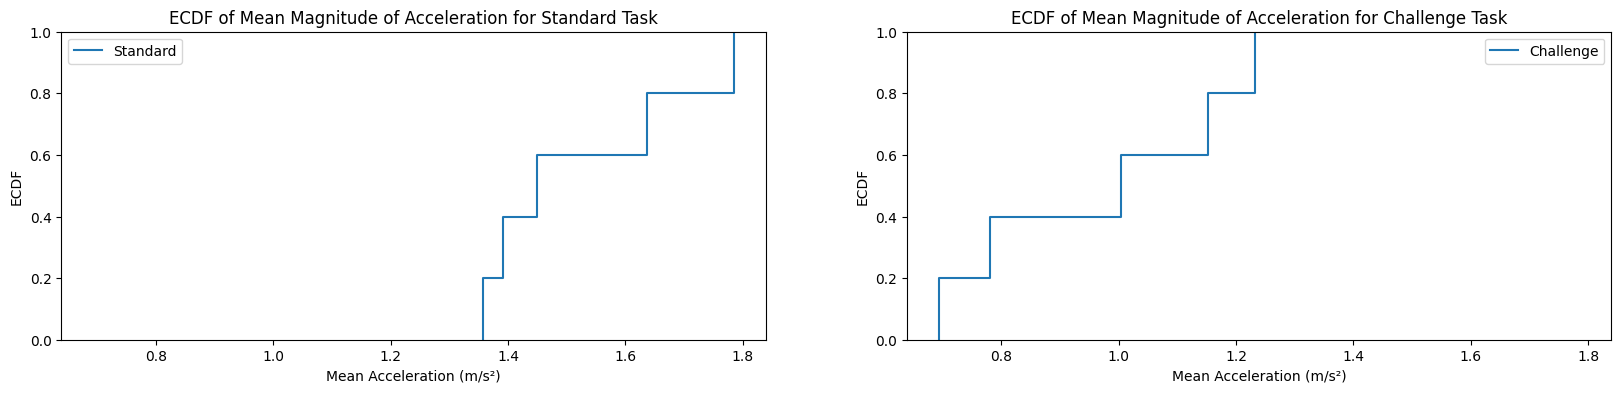

In [427]:
fig, axs = plt.subplots(1, 2, figsize=(20, 4), sharex=True)

sns.ecdfplot(mean_acceleration_standard_magnitude, label='Standard', ax=axs[0])
sns.ecdfplot(mean_acceleration_challenge_magnitude, label='Challenge', ax=axs[1])
axs[0].set_xlabel('Mean Acceleration (m/s²)')
axs[0].set_ylabel('ECDF')
axs[0].set_title('ECDF of Mean Magnitude of Acceleration for Standard Task')
axs[0].legend()

axs[1].set_xlabel('Mean Acceleration (m/s²)')
axs[1].set_ylabel('ECDF')
axs[1].set_title('ECDF of Mean Magnitude of Acceleration for Challenge Task')
axs[1].legend()





In [428]:
# Perform t-test for the magnitude of mean acceleration of standard and challenge tasks
mean_acc_standard = [df['acceleration_magnitude'].mean() for df in dfs_stand]
mean_acc_challenge = [df['acceleration_magnitude'].mean() for df in dfs_stand_challenge]

print(mean_acc_standard)
print(mean_acc_challenge)

[np.float64(1.7848878692954853), np.float64(1.636891837767239), np.float64(1.3923158522778347), np.float64(1.3570905500926835), np.float64(1.4502362050831268)]
[np.float64(1.0040705073076044), np.float64(1.2330480911660822), np.float64(1.1522011601310023), np.float64(0.6932785640948899), np.float64(0.7811174815974915)]


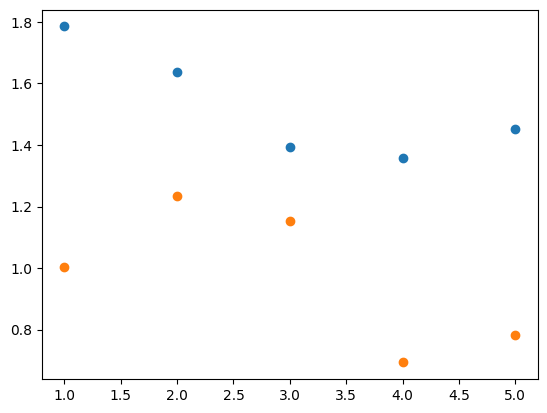

In [429]:
# Plot the magnitude of acceleration for each participant as a scatter plot
import matplotlib.pyplot as plt

participants = range(1, len(mean_acc_challenge) + 1)

plt.scatter(participants, mean_acc_standard, label='Standard')
plt.scatter(participants, mean_acc_challenge, label='Challenge')


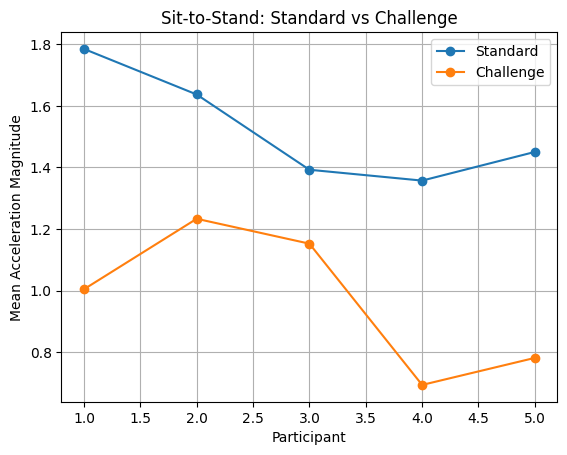

In [430]:
# Plot a bar chart of mean acceleration of standard and challenge tasks
participants = range(1, len(mean_acc_challenge) + 1)

plt.plot(participants, mean_acc_standard, marker='o', label='Standard')
plt.plot(participants, mean_acc_challenge, marker='o', label='Challenge')
plt.xlabel("Participant")
plt.ylabel("Mean Acceleration Magnitude")
plt.title("Sit-to-Stand: Standard vs Challenge")
plt.legend()
plt.grid(True)
plt.show()

In [431]:
# Paired t-test for the magnitude of mean acceleration of standard and challenge tasks
from scipy.stats import ttest_rel

t_stat, p_value = ttest_rel(mean_acc_standard, mean_acc_challenge)
print("Paired t-test result: \n")
print(f"t-statistic = {t_stat:.4f}")
print(f"p-value = {p_value:.4f}")

Paired t-test result: 

t-statistic = 5.5460
p-value = 0.0052


In [432]:
# Conclusion

print("Conclusion:")
print("*"*30)
if p_value < 0.05:
    print("There is a significant difference in the mean acceleration magnitude between the standard and challenge tasks.")
else:
    print("There is no significant difference in the mean acceleration magnitude between the standard and challenge tasks.")



Conclusion:
******************************
There is a significant difference in the mean acceleration magnitude between the standard and challenge tasks.
